In [ ]:
!pip3 install pycuda

     |████████████████████████████████| 1.6MB 8.1MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4535938 sha256=e2adee4a854701cccb2d2220e2630e675961cfe6644cb73d06dd3e3f9c729795
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.2-py2.py3-none-any.whl size=62338 sha256=36a872b0ece0c2325187186c1b267d20528bfdfda180baf45482e810fc44b729
  Stored in directory: /root/.cache/pip/wheels/a7/d6/ac/03a67d071bde6d272d1f7c9ab7f4344fa9d7b9d98bda7fd127
Successfully built pycuda pytools


In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pycuda.autoinit

In [ ]:
module = SourceModule("""
#define NUM_THREADS 128
#define NUM_HALO 2
__global__ void rolling_mean_1d(int nx, float *res, float *arr){
    __shared__ float arr_s[NUM_THREADS + NUM_HALO];
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int tx = threadIdx.x + 1;
    float arr_mean;
    if (x < nx){
        arr_s[tx] = arr[x];
        if (x == 0){
            arr_s[tx - 1] = arr[0];
        } else if (x == (nx - 1)){
            arr_s[tx + 1] = arr[nx - 1];
        } else {
            if ((tx - 1) == 0){
                arr_s[tx - 1] = arr[x - 1];
            } else if ((tx + 1) == NUM_THREADS){
                arr_s[tx + 1] = arr[x + 1];
            }
        }
        __syncthreads();
        arr_mean = (arr_s[tx - 1] + arr_s[tx] + arr_s[tx + 1]) / 3.0;
        res[x] = arr_mean;
    }
}
""")

In [ ]:
rolling_mean = module.get_function("rolling_mean_1d")

In [ ]:
num_components = np.int32(200)
x = np.linspace(0, 5, num_components, dtype=np.float32)

In [ ]:
arr = np.sin(x) + 0.1 * np.random.randn(num_components).astype(np.float32)

In [ ]:
arr_gpu = gpuarray.to_gpu(arr)
res_gpu = gpuarray.zeros(num_components, dtype=np.float32)

In [ ]:
num_threads = 128
threads_per_block = (num_threads, 1, 1)
blocks_per_grid = (math.ceil(num_components / threads_per_block[0]), 1, 1)

In [ ]:
rolling_mean(num_components, res_gpu, arr_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res = res_gpu.get()

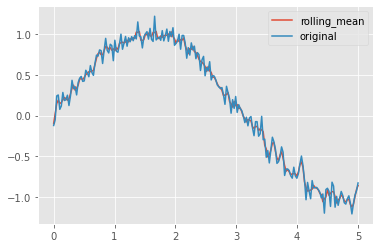

In [ ]:
plt.plot(x, res, label="rolling_mean")
plt.plot(x, arr, label="original")
plt.legend()
plt.show()